In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# change directory to the root of the project
from os import chdir

chdir("../..")

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from shapely.geometry import Point

In [4]:
# metadata stations info
stations = pd.read_parquet("data/input/stations/metadata.parquet")

# heatwaves reasearch stations
hw_stations = pd.read_parquet("data/input/stations/hw_research_stations.parquet")

# stations_ts_gap
stations_ts_gap = pd.read_parquet("data/reporting/stations_ts_gap.parquet")

# satations_mk test
stations_mk_test = pd.read_parquet("data/reporting/stations_mk_test.parquet")[["trend", "slope"]]

# join -> (34 - 1) hw_research stations
hw_stations = (
    stations.join(hw_stations[["min_year", "max_year"]], how="right")
    .join(stations_ts_gap, how="left")
    .join(stations_mk_test, how="left")
)

# drop bad stations
bad_stations = [
    270002,  # missing data
    950001,  # south
]
for station_id in bad_stations:
    hw_stations.drop(station_id, inplace=True)

# drop before correcing type to avoid NA conversion error
hw_stations.dropna(subset=["name"], inplace=True)

# fix types
int_cols = [
    "WMO_code",
    "altitude",
    "state_id",
    "geographic_zone_id",
    "min_year",
    "max_year",
    "ts_days",
    "data_days",
    "gap_days",
]
hw_stations = hw_stations.astype({col: int for col in int_cols})
print(f"hw_stations shape: {hw_stations.shape}")

hw_stations  # 26 stations

hw_stations shape: (26, 17)


,WMO_code,ICAO_code,name,latitude,longitude,altitude,state_id,geographic_zone_id,data_link,min_year,max_year,ts_days,data_days,gap_days,gap_%,trend,slope
national_code,,,,,,,,,,,,,,,,,
180005,85406,SCAR,"Chacalluta, Arica Ap.",-18.35555,-70.34028,50,15,1,https://climatologia.meteochile.gob.cl/applica...,1955,2023,15602,15600,2,0.012819,no trend,-0.277232
200006,85418,SCDA,Diego Aracena Iquique Ap.,-20.54917,-70.18111,48,1,1,https://climatologia.meteochile.gob.cl/applica...,1981,2023,15602,15509,93,0.596077,no trend,-0.053846
220002,85432,SCCF,"El Loa, Calama Ad.",-22.49806,-68.89250,2321,2,2,https://climatologia.meteochile.gob.cl/applica...,1965,2023,15602,15598,4,0.025638,NaN,NaN
270001,85469,SCIP,Mataveri Isla de Pascua Ap.,-27.15889,-109.43250,44,5,1,https://climatologia.meteochile.gob.cl/applica...,1954,2023,15602,15596,6,0.038457,no trend,0.131579
290004,85488,SCSE,"La Florida, La Serena Ad.",-29.91444,-71.20667,137,4,3,https://climatologia.meteochile.gob.cl/applica...,1954,2023,15602,15589,13,0.083323,no trend,0.152083
300046,85502,,"Vicuña, Parque Los Pimientos",-30.03361,-70.69722,642,4,5,https://climatologia.meteochile.gob.cl/applica...,2017,2023,2453,2162,291,11.863025,NaN,NaN
310024,85523,,Liceo Samuel Román Rojas (Combarbalá),-31.18805,-70.99889,936,4,2,https://climatologia.meteochile.gob.cl/applica...,2011,2023,3184,2460,724,22.738693,NaN,NaN
320019,85537,,San Felipe Escuela Agrícola,-32.75528,-70.70694,662,5,5,https://climatologia.meteochile.gob.cl/applica...,2019,2023,1716,1491,225,13.111888,NaN,NaN
330007,85560,SCRD,"Rodelillo, Ad.",-33.06528,-71.55639,330,5,1,https://climatologia.meteochile.gob.cl/applica...,1971,2023,15602,15554,48,0.307653,increasing,0.494782


In [5]:
# Chile states
states = (  # EPSG:3857 (WGS 84 / Pseudo-Mercato)
    gpd.read_file("data/input/shapefiles/states/states.shp")
    .iloc[:, 2:]
    .rename(columns={"codregion": "state_id", "Region": "state_name"})
    .set_index("state_id", drop=True)
    .sort_index()
)
states

,area_km,st_area_sh,st_length_,state_name,geometry
state_id,,,,,
0,3937.432096,9.306245e+09,3.887224e+05,Zona sin demarcar,"POLYGON ((-8197676.045 -6303383.769, -8112196...."
1,42284.567484,4.830637e+10,1.213713e+06,Región de Tarapacá,"MULTIPOLYGON (((-7810213.515 -2298008.280, -78..."
2,126071.431981,1.508452e+11,2.516112e+06,Región de Antofagasta,"MULTIPOLYGON (((-7870470.961 -2985679.186, -78..."
3,75661.248635,9.643906e+10,2.401741e+06,Región de Atacama,"MULTIPOLYGON (((-7932747.769 -3311218.615, -79..."
4,40575.901682,5.498082e+10,2.065933e+06,Región de Coquimbo,"MULTIPOLYGON (((-7963268.900 -3784870.143, -79..."
5,16322.970393,2.301475e+10,1.679609e+06,Región de Valparaíso,"MULTIPOLYGON (((-8991645.917 -3991821.789, -89..."
6,16349.029957,2.409028e+10,9.848526e+05,Región del Libertador Bernardo O'Higgins,"MULTIPOLYGON (((-8002300.862 -4023671.372, -80..."
7,30321.890658,4.596943e+10,1.388328e+06,Región del Maule,"POLYGON ((-8018823.211 -4121471.456, -8018820...."
8,24021.621594,3.817612e+10,2.097147e+06,Región del Bío-Bío,"MULTIPOLYGON (((-8231985.748 -4624218.142, -82..."


In [ ]:
# TODO: chequear los trends de hw_intensity para el norte (para ver si hay tendencias cuadráticas o de otra índole)

In [34]:
geo_stations["trend"]

national_code
180005      no trend
200006      no trend
220002           NaN
270001      no trend
290004      no trend
300046           NaN
310024           NaN
320019           NaN
330007    increasing
330020    increasing
330030           NaN
340031    increasing
340045           NaN
360011    increasing
360019           NaN
370033           NaN
380013    increasing
390006    increasing
400009    increasing
410005           NaN
430002      no trend
450001      no trend
450004    increasing
450005    increasing
520006    increasing
550001    increasing
Name: trend, dtype: object

no trend 6
nan 9
increasing 11


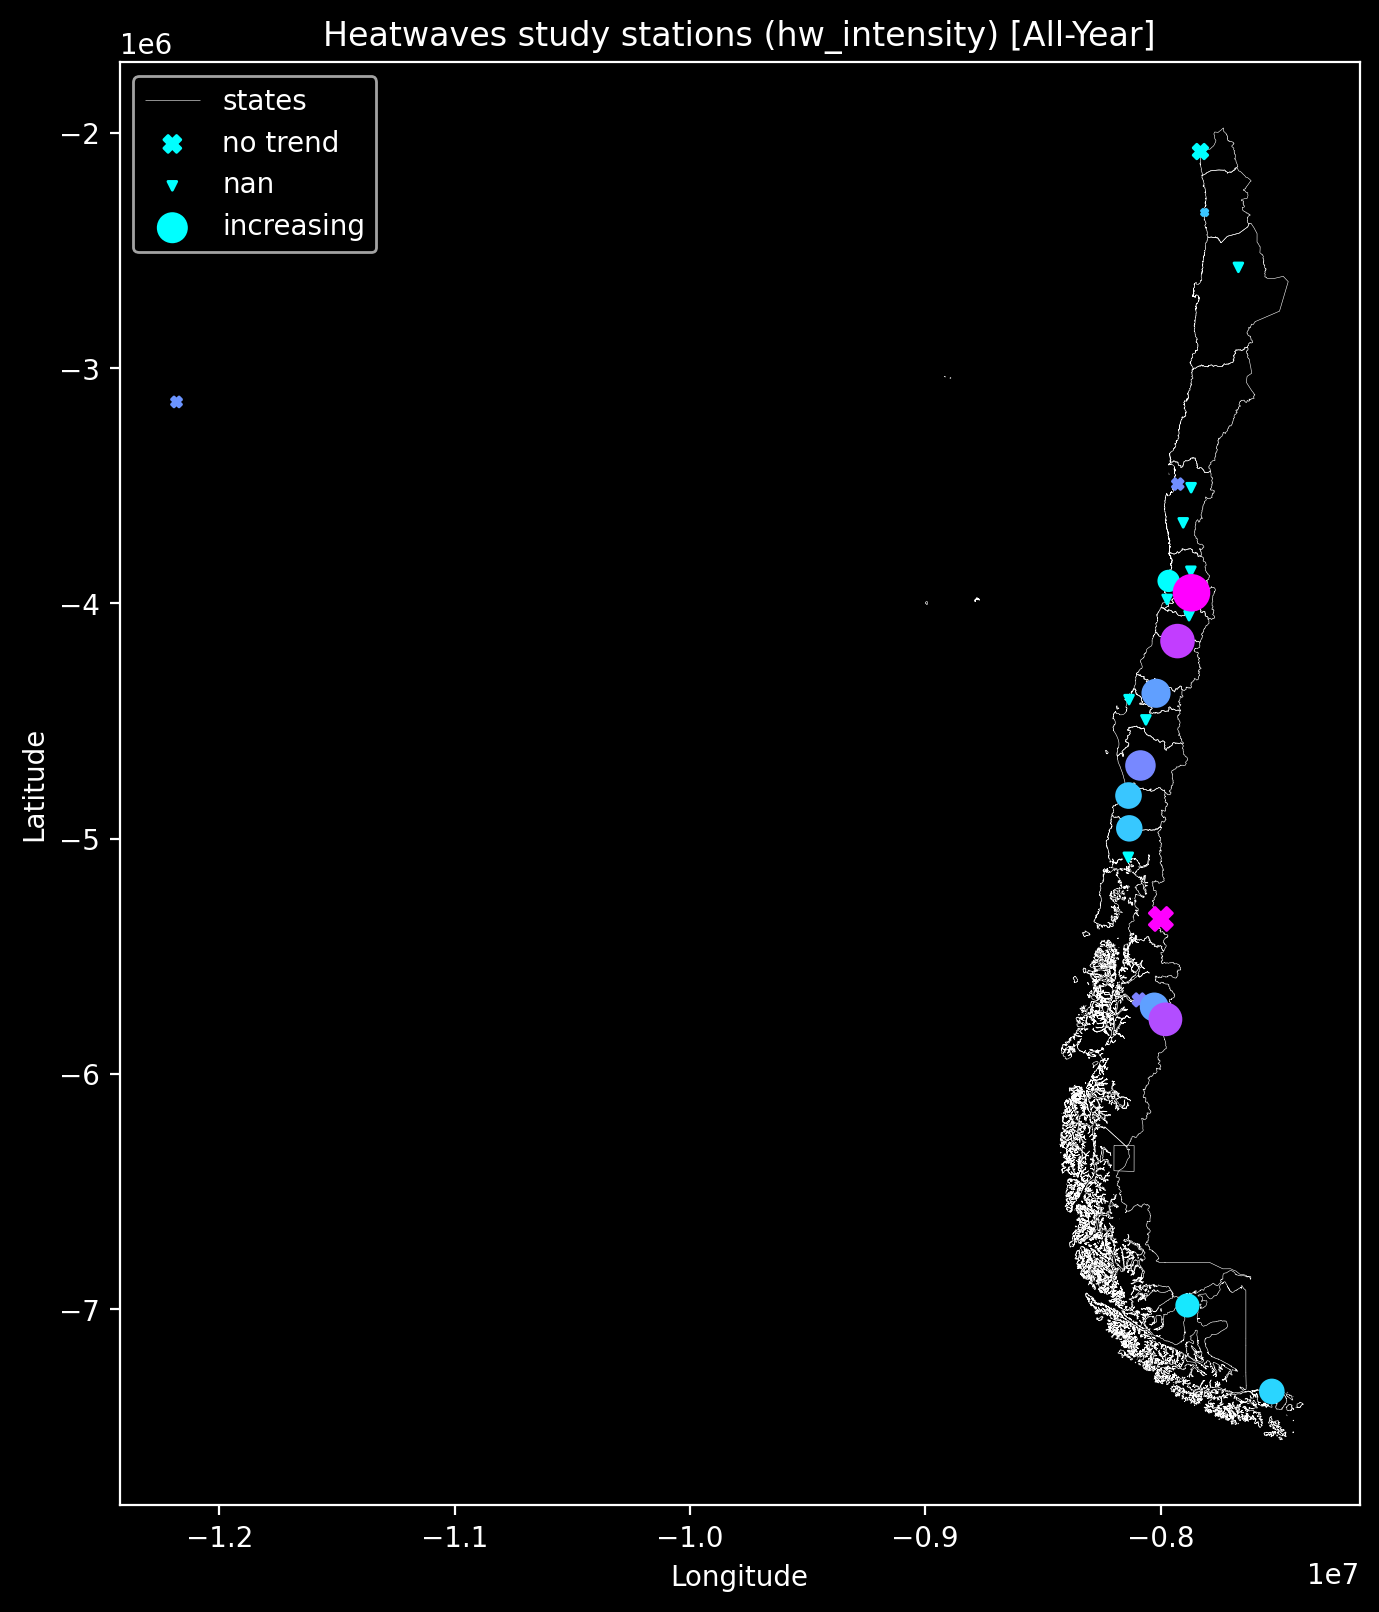

In [9]:
fig, ax = plt.subplots(figsize=(8, 10))

# plot stations geographically
hw_stations.loc[:, "geometry"] = hw_stations.apply(  # long, lat -> EPSG:3857
    lambda x: Point(x.longitude, x.latitude) if (x.longitude and x.latitude) else pd.NA, axis=1
)
geo_stations = gpd.GeoDataFrame(
    hw_stations,
    crs="EPSG:4326",
    geometry="geometry",
)
geo_stations.to_crs("EPSG:3857", inplace=True)  # to further comply with Chile states shapefile

states.boundary.plot(
    ax=ax,
    lw=0.2,
    label="states",
    zorder=1,
)

# plot stations:
# - color: hw_intensity
# - marker : trend, "*" if "increasing", else "o"
trends = geo_stations["trend"].unique()
for trend in trends:
    mask = geo_stations["trend"] == trend if trend is not np.nan else geo_stations["trend"].isna()
    marker = "o" if trend == "increasing" else "X" if trend == "no trend" else "v"

    print(trend, len(geo_stations[mask]))
    if trend is np.nan:
        geo_stations_modified = geo_stations[mask].copy()
        geo_stations_modified["slope"] = 0.1
        geo_stations_modified.plot(
            ax=ax,
            column="slope",
            cmap="cool",
            markersize=geo_stations_modified["slope"].map(lambda _: 10),
            marker=marker,
            zorder=2,
            label=trend,
        )
    else:
        geo_stations[mask].plot(
            ax=ax,
            column="slope",
            cmap="cool",
            markersize=geo_stations[mask]["slope"]
            .map(lambda x: x if x is not np.nan else 100)
            .abs()
            * 100,
            marker=marker,
            zorder=2,
            label=trend,
        )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

plt.title("Heatwaves study stations (hw_intensity) [All-Year]")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# TODO: slope, size, markertype

# TODO: find shapefile with less detail in councils limits (South of Chile)
# TODO: marker_type -> yes | no on [season]
# TODO: experiment with -> Easter Island in box | Chile horizontal to decrease null spaces in plot

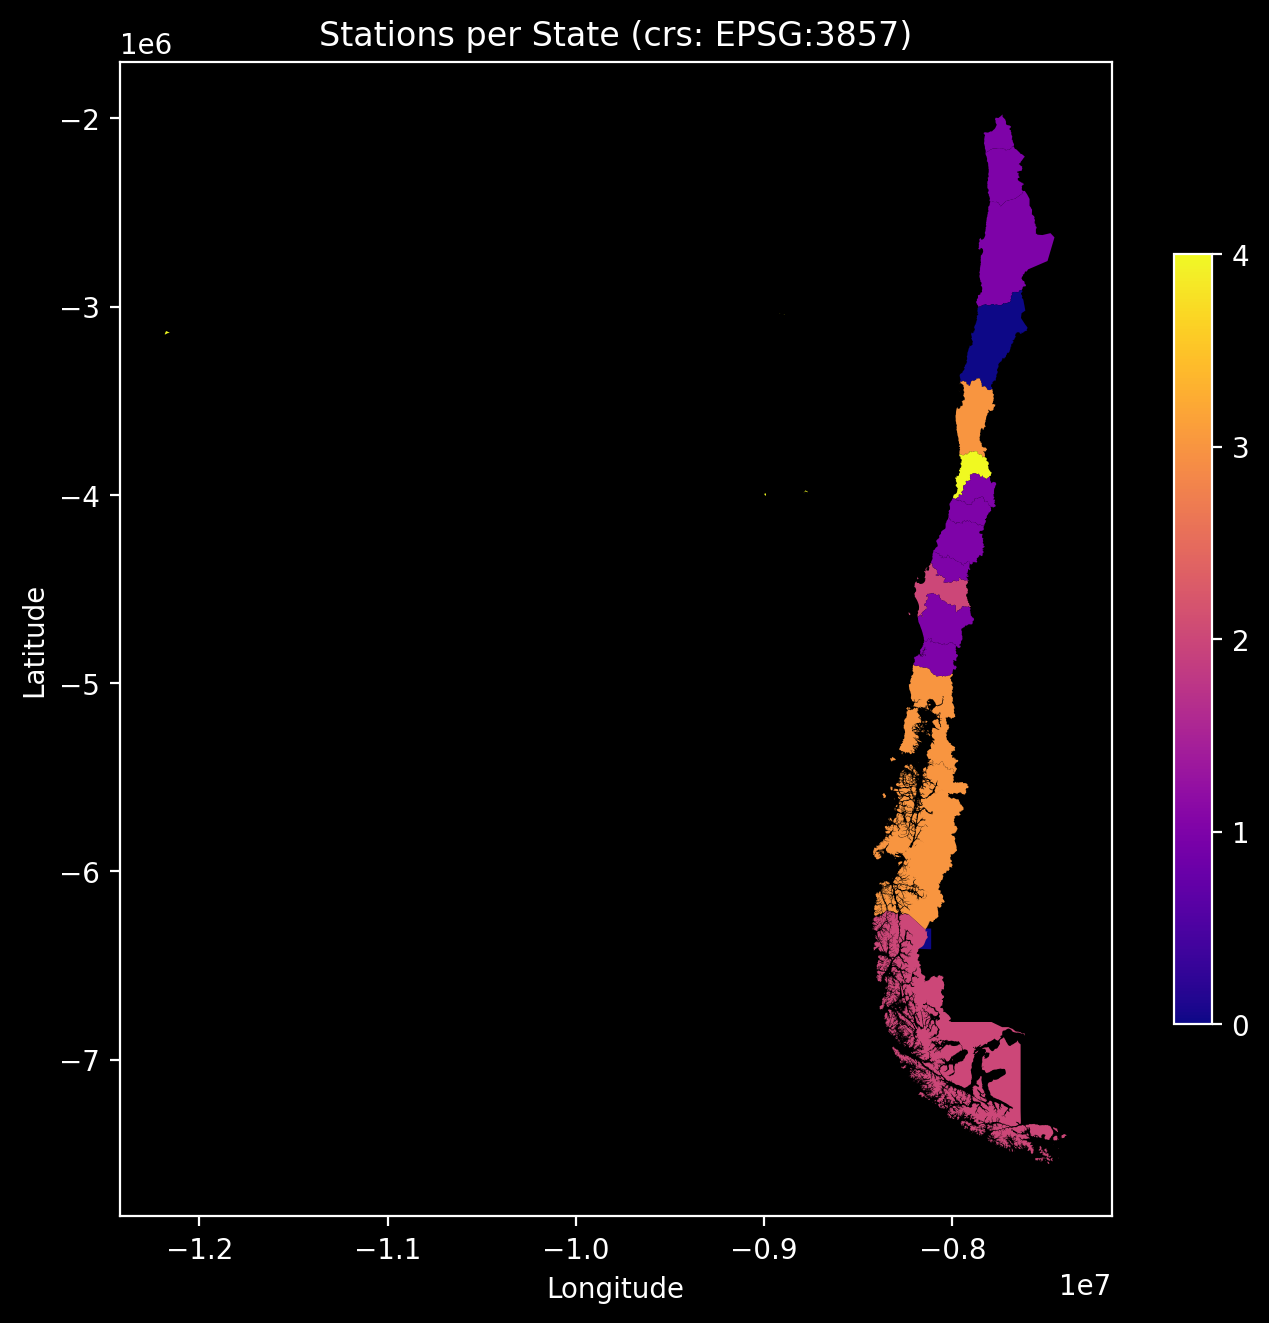

In [28]:
stations_cnt = (
    states.join(hw_stations["state_id"].value_counts().rename("stations_cnt"))
    .fillna(0)
    .astype({"stations_cnt": int})
)
fig, ax = plt.subplots(figsize=(8, 10))
stations_cnt.plot(
    column="stations_cnt",
    ax=ax,
    cmap="plasma",
    legend=True,
    legend_kwds={
        "shrink": 0.5,
        "ticks": [i for i in range(stations_cnt["stations_cnt"].max() + 1)],
    },
)

plt.title("Stations per State (crs: EPSG:3857)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()